<img src="gas_station_orig.jpg">

### The Gas
At the gas station, i have the habit switch between SP98 and E10. E10 is sold less expensive, however, the car consumes more of it per 100km. By feeling i would say it is between 0.5 and 1 liter more per 100km - which is, taken by logic, ridiculous lots, so i didn't believe my feeling.

I want to try and find the real impact on the consumption today. 

### My question is: 
Is this higher consumption of E10 eating the better price or not? Asked the other way round: Is E10 fuel in the end really less expensive or not?

In [1]:
E10_price = 1.379
SP98_price = 1.459

E10 contains 10% alcohol and is otherwise "super" fuel, sold as "95" in some countries. SP98 is the fuel sold as "super plus" or "super 98".

This consumption difference between two fuels is difficult to find because my car uses more or less gas depending on the weather, the traffic conditions, my personal mood, the speed, and the length of the route. For this first try, i did not connect to the CAN bus, so i had no information about the motor temperature and only one measurement per ride, taken by hand. As if it was not difficult enough, the Prius needs only one refill per month, so the season was changing while i did the recording.

I orient myself on an R script of [Victor Chernozhukov](http://www.mit.edu/~vchern/); who was beautifully extracting the influence on being female on the salary. However, he used R which i don't know, so i try to repeat this in python. 

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from IPython.display import display #, HTML
from patsy import dmatrices
import matplotlib.pyplot as plt

#%matplotlib inline
%matplotlib notebook

C:\Users\Andreas\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df = pd.read_excel('measurements2.xlsx')
display(df.head(6))

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain
0,28.0,5.0,26,21.5,12,NaN,E10,0,0
1,12.0,4.2,30,21.5,13,NaN,E10,0,0
2,11.2,5.5,38,21.5,15,NaN,E10,0,0
3,12.9,3.9,36,21.5,14,NaN,E10,0,0
4,18.5,4.5,46,21.5,15,NaN,E10,0,0
5,8.3,6.4,50,21.5,10,NaN,E10,0,0


* distance is the distance in kilometers i was driving
* consume is the consumption in liters per 100 kilometers as seen in the display
* speed is the average speed. 
* temp_inside is the setting of the heating or "NaN" if it was turned off
* temp_outside is the temperature outside, taken at the end of the ride.
* specials is a remark if it was raining, snowing or if the climatization was on ("AC")
* gas type is the gas type used during the last refill
* AC is one hot encoded, the special "AC". 1 for on, 0 for off.
* rain is one-hot-encoded, the special "rain" and "snow". 1 for it was raining/snowing, 0 for it was good weather.

Let's do some graphics.

<IPython.core.display.Javascript object>


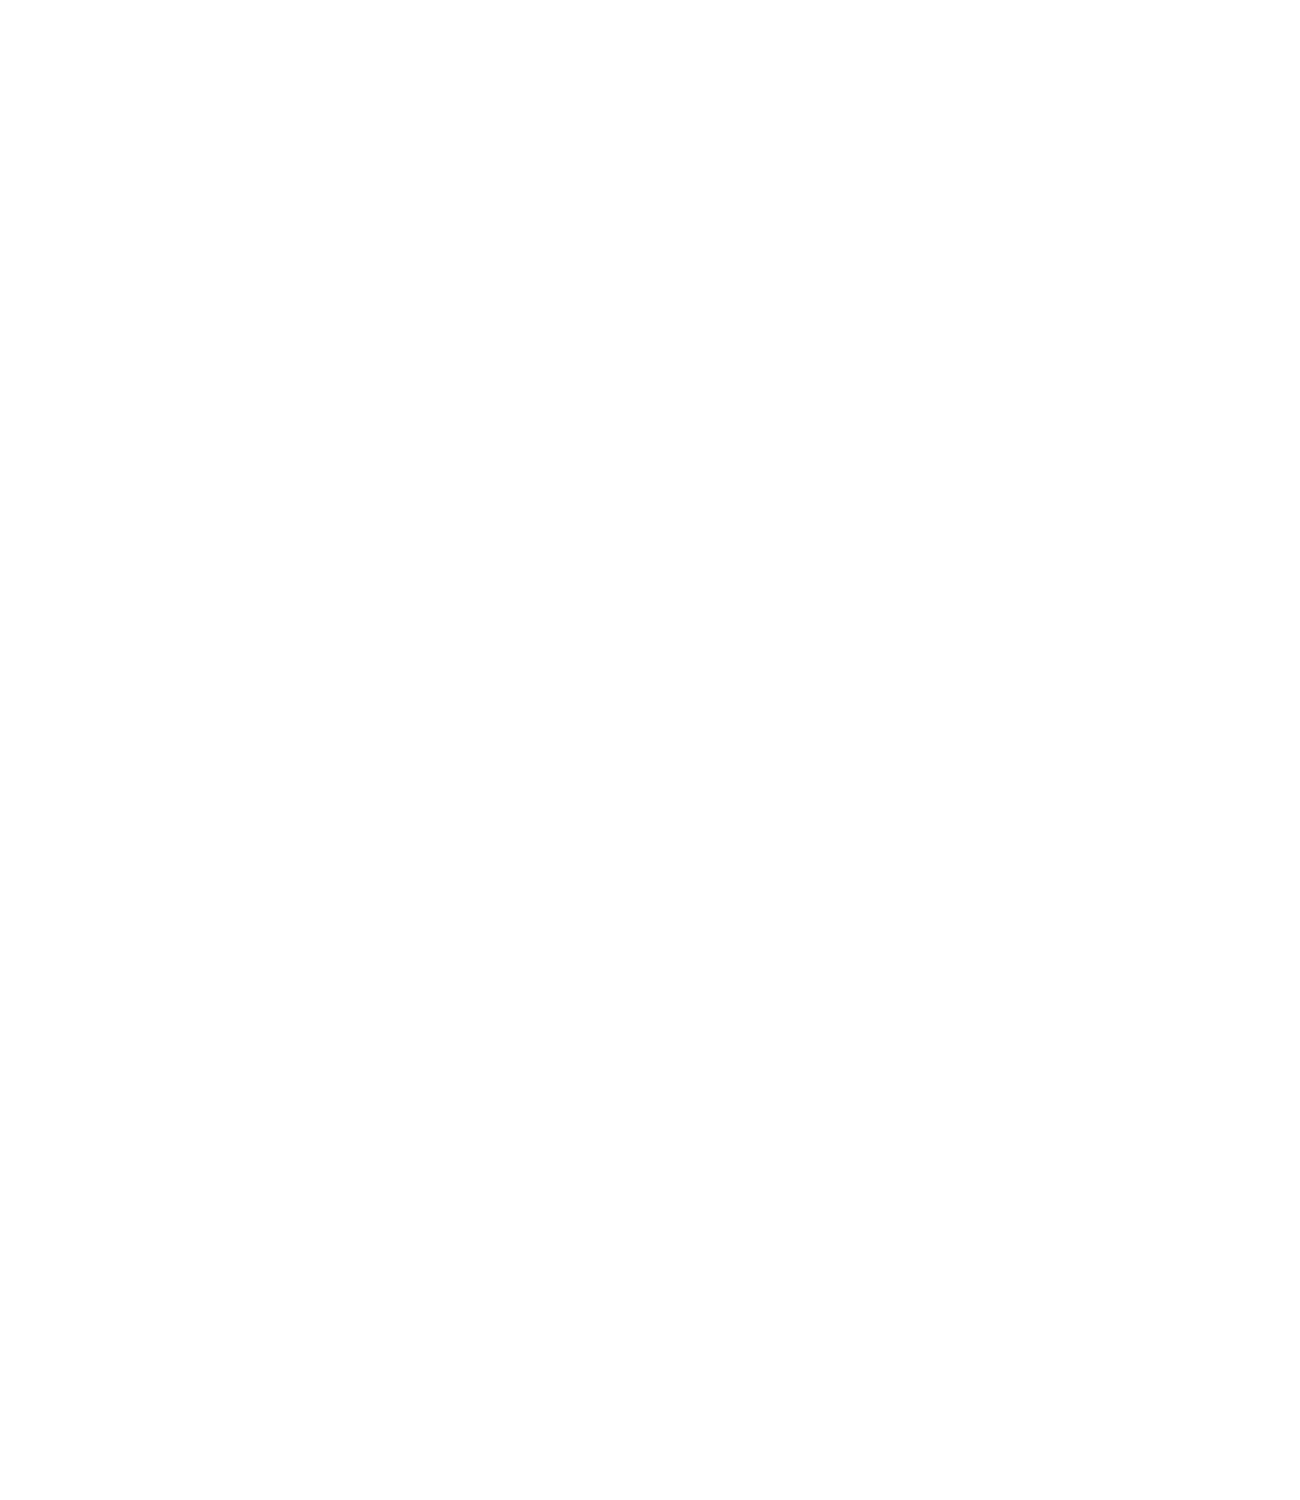

In [4]:
fig, axarr = plt.subplots(3,1)
fig.set_size_inches(w=13, h=15)
red_halo = (1., 0, 0, 0.07)
# plot of speed
axarr[0].scatter(df.speed.values, df.consume.values, color=red_halo, s=400, marker='o', linewidths=0)
axarr[0].scatter(df.speed.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
axarr[0].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[0].set_xlabel('Speed in km/h')
axarr[0].set_ylabel('consume in L/100km')

#plot of distances
axarr[1].scatter(df.distance.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
axarr[1].scatter(df.distance.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
axarr[1].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[1].set_xlabel('Distance in km')
axarr[1].set_ylabel('consume in L/100km')

#plot of outside temperature
axarr[2].scatter(df.temp_outside.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
axarr[2].scatter(df.temp_outside.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
axarr[2].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[2].set_xlabel('outside temperature in °C')
text = axarr[2].set_ylabel('consume in L/100km')

Every datapoint has a red halo, so that one can see overlaps like on a heat map.

Notably the distance has some outliers. I did this analysis with and without those outliers: The consumption prediction stays roughly the same; the difference is about +/- 0.1 L/100km. So for the moment i keep them - the weather gets better, so i might measure some more long distance "outliers" soon. :-) The way to work is 12 km long, so that's where that big blob comes from.

Just because i wanted to try it once, a 3D plot. Also i hope to spread my blob of commute traffic a little bit:

<IPython.core.display.Javascript object>


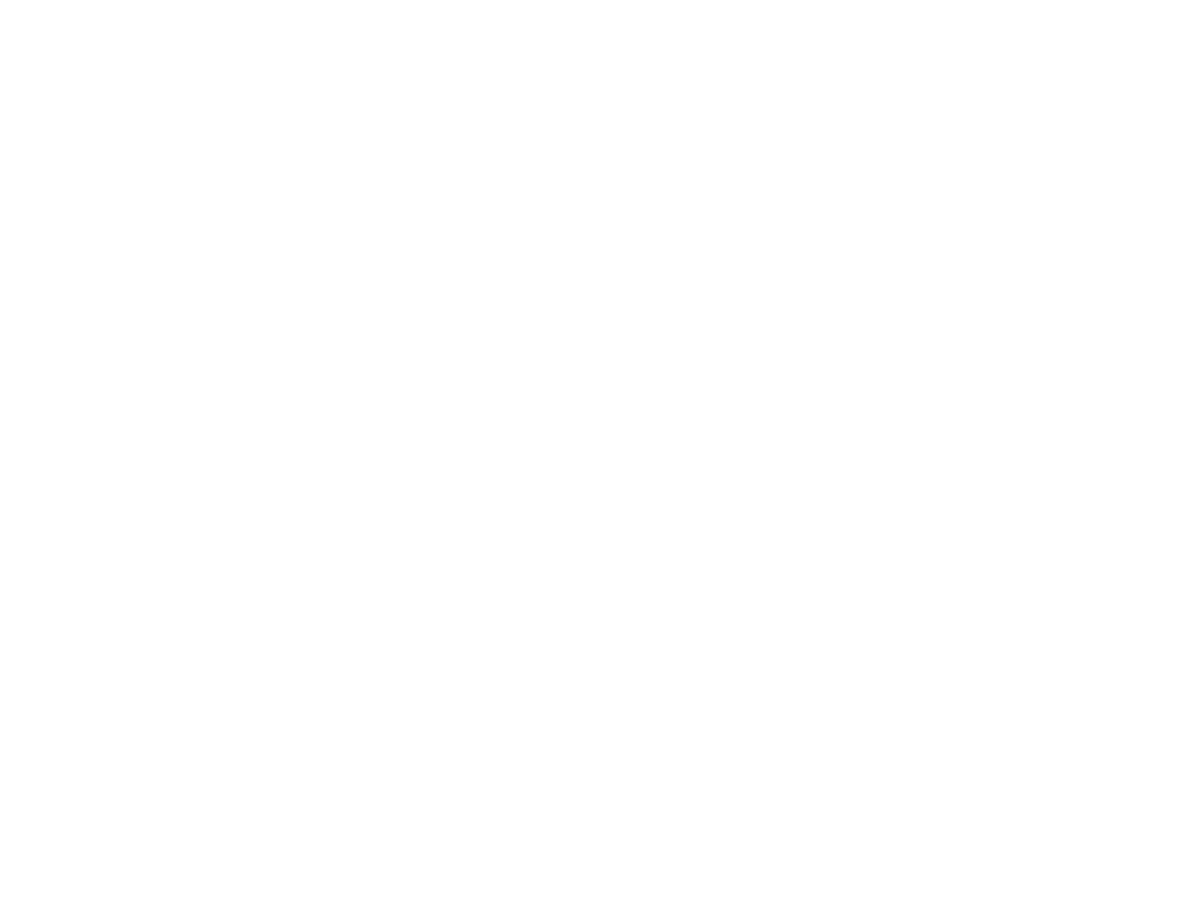

In [5]:
# switch to interactive chart format
%matplotlib notebook 
# %matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D
alpha = 0.1
fig = plt.figure()
fig.set_size_inches(w=12, h=9)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.speed.values, df.distance.values,  df.consume.values,  
           color='r', s=400, marker='o', alpha=alpha, linewidths=0)
ax.scatter(df.speed.values, df.distance.values,  df.consume.values,   
           color='#000000', s=5, marker='o', alpha=1, linewidths=0)


ax.set_xlabel('Speed in km/h')
ax.set_ylabel('Distance in km')
ax.set_ylim(0, 60) # exclude the two outliers from the graphic
text = ax.set_zlabel('Consume in L/100km')

This graph shows nicely that the big blob of commute traffic takes place at very different speeds. If you have opened this using Jupyter, you can turn it if you like.

### Some features
Let's see what we can extract from that.

In [6]:
# indicator if the heating was not used at all
df['heating_off']=df['temp_inside'].isnull()
df['heating_off']=df['heating_off'].apply(float)
# if the heating was turned completely off, replace the inside temperature by the outside temperature
df['temp_inside'].fillna(df['temp_outside'], inplace=True)
# get the temperature difference
df['temp_diff'] = df['temp_inside'] - df['temp_outside']
df['temp_diff_square'] = df['temp_diff']**2
# add the square and cube of the speed to the frame
df['speedsquare'] = df['speed']**2  # 5% better accuracy
df['speedcube'] =  df['speed']**3  # 1% better accuracy

# translate the gas type to something machine readable
def gastype(in_string):
    '''gas type in, integer out'''
    if in_string == "E10":
        return 0
    else:
        return 1
df['gas_type_num']= df['gas_type'].apply(gastype)
print(df.groupby(by='gas_type')['consume'].mean().round(2))

gas_type
E10     5.12
SP98    5.25
Name: consume, dtype: float64


So yes there is indeed an impact of the gas type. Contrary to my real life experience it looks as if SP98 makes my car consume more, and that the difference is very small! This is because i used SP98 throughout the winter, while E10 was used before and after. I need to refill only once per month so it is difficult to have both gas types in the same season.

The start phase is the most costly: The first three minutes, the motor runs without necessity, just to heat up. It becomes worse when the heating is on. So i made a sigmoid-function separating short rides from the rest. Being a little bit suspicious of my hand-crafted "startphase" value, i plot it. 

Short rides can be determined by dividing the distance by the speed - that's an indirect timer. The sigmoid function can be customized by substracting a delay (moving the 50%-point where i want it); and multiplying with a slope value (making the function brutally steep or nondecisive flat as i like).

I found the best values for both, delay and slope, by displaying a regression line and repeatedly checking it's R² until a nice maximum had been found. A mathematically sound gradient descent would have been much faster and cleaner: I took that note for next time!

<IPython.core.display.Javascript object>


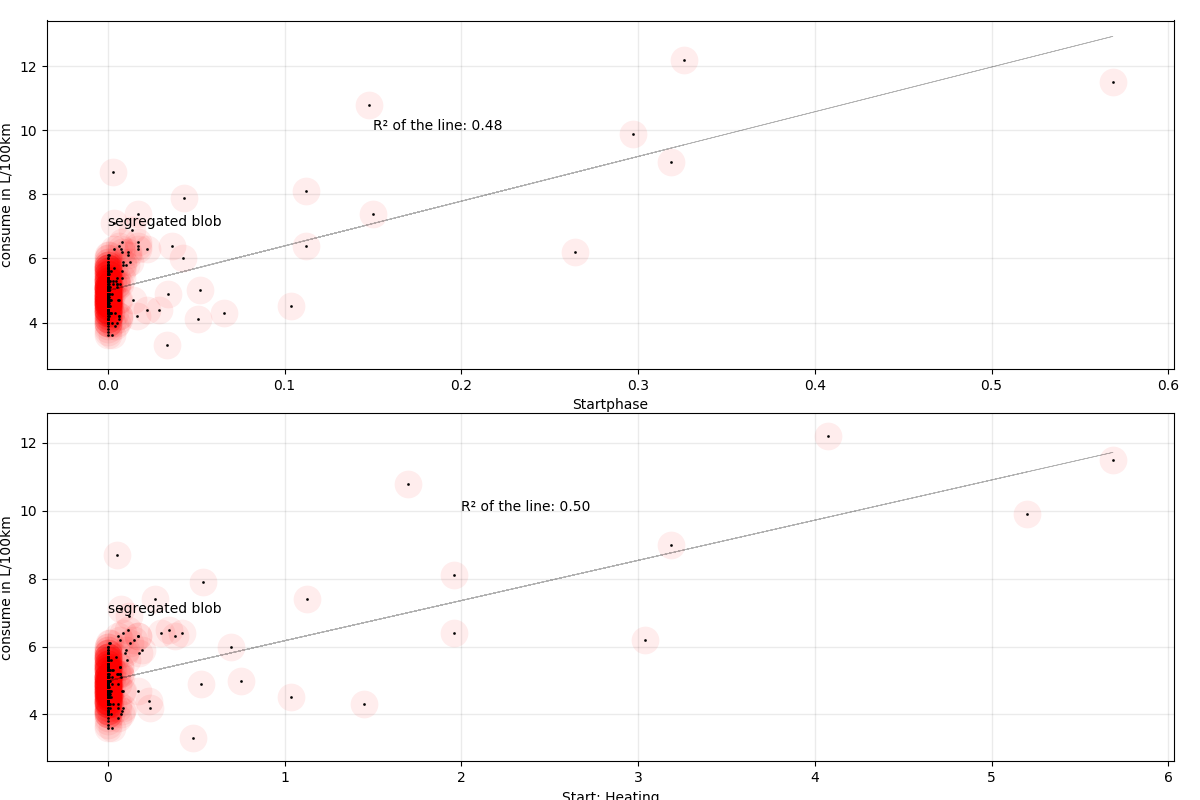

In [7]:
# use interactive graphic format
%matplotlib notebook
# %matplotlib inline
from ipywidgets import *

slope = 34.1 # get down rather fast.
delay = 0.07 # after 8% of an hour, equals 5 minutes, cut off.

df['startphase'] = 1 / (1 + np.exp( ((df['distance']/df['speed'])-delay)* slope))

#check the additional worth of it
rgr = LinearRegression()
rgr.fit(df.startphase.values.reshape(-1, 1), df.consume.values)
regression_fit = 'R² of the line: {:.2f}'.format(rgr.score(df.startphase.values.reshape(-1, 1), df.consume.values))

fig, axarr = plt.subplots(2,1)
fig.set_size_inches(w=12, h=8)
fig.tight_layout()
alpha = 0.05
# plot of startphase
line0, = axarr[0].plot(df.startphase.values,  df.startphase.values*rgr.coef_[0]+rgr.intercept_, 
                       color='#000000', alpha=.3, linewidth=0.5)
text0 = axarr[0].text(0.15, 10, regression_fit)
halo0 = axarr[0].scatter(df.startphase.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
poin0 = axarr[0].scatter(df.startphase.values, df.consume.values, color='#000000', s=1, marker='o', alpha=.9)
axarr[0].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[0].set_xlabel('Startphase')
axarr[0].set_ylabel('consume in L/100km')
axarr[0].text(0.0, 7, 'segregated blob')


# heating costs extra in the startphase, later not so much
df['start_heating'] = df['startphase'] * df['temp_diff'] 
#check the additional worth of it
rgr = LinearRegression()
rgr.fit(df.start_heating.values.reshape(-1, 1), df.consume.values)
regression_fit = 'R² of the line: {:.2f}'.format(rgr.score(df.start_heating.values.reshape(-1, 1), df.consume.values))

#plot of start_heating
line1, = axarr[1].plot(df.start_heating.values, df.start_heating.values*rgr.coef_[0]+rgr.intercept_, 
                       color='#000000', alpha=.3, linewidth=0.5)
text1 = axarr[1].text(2, 10, regression_fit)
halo1 = axarr[1].scatter(df.start_heating.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
poin1 = axarr[1].scatter(df.start_heating.values, df.consume.values, color='#000000', s=1, marker='o', alpha=.9)
axarr[1].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[1].set_xlabel('Start: Heating')
axarr[1].text(0, 7, 'segregated blob')
text = axarr[1].set_ylabel('consume in L/100km')
fig.canvas.draw()

def update(slope, delay):
    df['startphase'] = 1 / (1 + np.exp( ((df['distance']/df['speed'])-delay)* slope))
    rgr = LinearRegression()
    rgr.fit(df.startphase.values.reshape(-1, 1), df.consume.values)
    score = rgr.score(df.startphase.values.reshape(-1, 1), df.consume.values)
    #text0.set_position(0.4, 10)
    text0.set_text('R² of the line: {:.2f}'.format(score))
    line0.set_data(df.startphase.values, df.startphase.values*rgr.coef_[0]+rgr.intercept_)
    halo0.set_offsets(np.c_[df.startphase.values, df.consume.values])
    poin0.set_offsets(np.c_[df.startphase.values, df.consume.values])

    df['start_heating'] = df['startphase'] * df['temp_diff'] 
    #check the additional worth of it
    rgr = LinearRegression()
    rgr.fit(df.start_heating.values.reshape(-1, 1), df.consume.values)
    score = rgr.score(df.start_heating.values.reshape(-1, 1), df.consume.values)

    text1.set_text('R² of the line: {:.2f}'.format(score))
    line1.set_data(df.start_heating.values, df.start_heating.values*rgr.coef_[0]+rgr.intercept_)
    halo1.set_offsets(np.c_[df.start_heating.values, df.consume.values])
    poin1.set_offsets(np.c_[df.start_heating.values, df.consume.values])
    
    fig.canvas.draw()

def plot_interactive():
    slope_w = widgets.FloatSlider(description='slope', value=34.1, min=0, max=200, step=0.01,
                                 layout = Layout(width='50%', height='40px'))
    delay_w = widgets.FloatSlider(description='delay', value=0.070, min=0, max=0.2, step=0.001,
                                 layout = Layout(width='50%', height='40px'))
    interact(update, slope=slope_w, delay=delay_w)


In [8]:
plot_interactive()

With an R² of 0.5 this artificial feature looks fairly good - as indicator for the consumption it works better than any other feature so far. Remarkable: The better this feature fits the data, the less the overconsumption of E10 looks...

Just to be complete, a short draw of the last three features: Heating off, AC (clime), and rain. All three have a small but measurable impact...

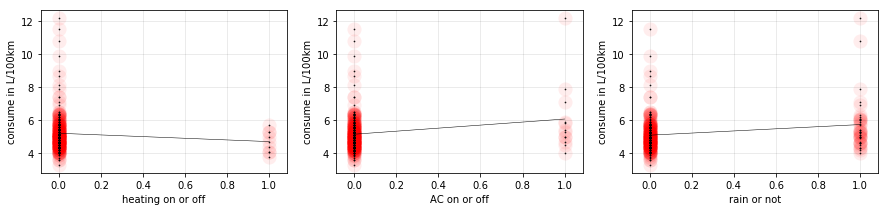

In [9]:
%matplotlib inline
rgr = LinearRegression()
fig, ax = plt.subplots(1,3)
fig.set_size_inches(w=15, h=3)
X=np.array([0,1.])
# plot of speed
rgr.fit(df.heating_off.values.reshape(-1, 1), df.consume.values)
ax[0].plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax[0].scatter(df.heating_off.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax[0].scatter(df.heating_off.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax[0].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax[0].set_xlabel('heating on or off')
ax[0].set_ylabel('consume in L/100km')

rgr.fit(df.AC.values.reshape(-1, 1), df.consume.values)
ax[1].plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax[1].scatter(df.AC.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax[1].scatter(df.AC.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax[1].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax[1].set_xlabel('AC on or off')
ax[1].set_ylabel('consume in L/100km')

rgr.fit(df.rain.values.reshape(-1, 1), df.consume.values)
ax[2].plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax[2].scatter(df.rain.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax[2].scatter(df.rain.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax[2].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax[2].set_xlabel('rain or not')
text = ax[2].set_ylabel('consume in L/100km')


Those are three booleans - the heating, if it is off, makes less consumption. The air conditioner raises the consumption, also the mere fact if it rains or not.

The last one was interesting: Why do i use more fuel if it rains? The air condition is sometimes on and sometimes off in the rain, so this is not the reason... Is it maybe the higher stress level in the traffic?

### The regression
First i tried to do the inference with sklearn first. There is no reason except that I used sklearn several times and feel comfortable with it.

#### The recipe
1. If you want to extract the influence of one feature, you have to make sure it is independent from the rest, otherwise it will not work. The gas type is independent from the rest, so here i am good.
2. Then you remove the to-be-tested feature from the rest of the feature space, exactly like the target variable.
3. Then you fit the regression on the target variable, `consume` in my case
4. A second regression with the same features is fitted on the `gas_type` as target
5. Finally, you fit the *residuals* of both regressions on each other. That captures two things: The influence of the gas type on the consume; but sadly also a part of the missing unexplained variance.

In [10]:
# make numpy vectors for prediction
prediction_values = ['distance','start_heating', 'startphase', 
                     'speed', 'speedsquare', 'speedcube', 
                     'temp_diff', 'temp_diff_square', 'temp_outside', 
                     'heating_off', 'AC', 'rain']
##############################################################
# in theory, the regression needs scaled data. However, 
# using scaled data had no effect. So scaling is not used today.
# scaler = StandardScaler()
# X_scale = scaler.fit_transform(df[prediction_values].values) 

X = df[prediction_values].values
Y = df['consume'].values
Y_gas = df['gas_type_num'].values

# apply regression
rgr = LinearRegression()
rgr.fit(X, Y)

# apply again, this time trained on gas type
rgr_gas = LinearRegression()
rgr_gas.fit(X, Y_gas)

# get the residuals (the not-yet-explained variance left in the data)
Y_residuals = Y - rgr.predict(X)
X_gas_residuals = Y - rgr_gas.predict(X)

# fit the residuals to get the influence of the gas type
# reshape(-1,1) is necessary since scikit 19 if you have a single feature
rgr_inference = LinearRegression()
rgr_inference.fit(X_gas_residuals.reshape(-1,1), Y_residuals)
difference = rgr_inference.coef_[0] # there is only one coef, but given as list of one. :-)

print('\nThe result after crossfitting two regressions to get the effect of gas sorts:')
print('The difference in consumption between E10 and SP98 is {:.2f} liter.'.format(difference))


# out of interest - what was the influence of the other factors?
print('\n\nThe importance of the other factors (F-Values)')
from sklearn.feature_selection import f_regression
F, pval = f_regression(X, Y)
predictors_df = pd.DataFrame(columns=prediction_values)
predictors_df.loc['F-value of predictor'] = F
print(predictors_df.round(2).transpose())
print('\nAnd R² of the model: {:.3f}'.format(rgr.score(X, Y)))


The result after crossfitting two regressions to get the effect of gas sorts:
The difference in consumption between E10 and SP98 is 0.39 liter.


The importance of the other factors (F-Values)
                  F-value of predictor
distance                          9.49
start_heating                   219.05
startphase                      208.88
speed                            18.47
speedsquare                       9.92
speedcube                         5.32
temp_diff                         4.89
temp_diff_square                  2.74
temp_outside                      5.12
heating_off                       1.64
AC                                7.38
rain                              9.42

And R² of the model: 0.646


Ok, there is the result, and there is also a confirmation that the artificial features have a tremendous impact on the result.

So far how it *should* work.

The Problem: `sklearn` is tuned to predictions and does not offer confidence intervals - so i don't know how reliable this result really is - or if it is a result at all. So i head over to `statsmodels` now.

In [11]:
# prepare dataframe for statsmodels
residuals = pd.DataFrame(Y_residuals, columns=['consume'])
residuals['E10']=X_gas_residuals

# fit regression in statsmodels format.
# it's like sklearn rgr.fit(E10, consume)
results = smf.ols('consume ~ E10', data=residuals).fit()

# get the result out of the vast array of available values
consume = results.conf_int().loc['E10']
# results.bse contains the standard error - if you want other confidence intervals...
print("The car uses between {:.2f} and {:.2f} L/100km more gas with E10, with 95% confidence".format(
            consume[0], consume[1]))

# assuming the difference is the beta of E10: attention, this
# is true only if the factor E10 is completely independent
difference = results.params[1]

#output results
print("\nThe mid point is {:.2f}L/100km".format(difference))
print('Here, E10 costs {:1.2f}€ and SP98 costs {:1.2f}€.\n\nSo, for 100 km:'.format(E10_price, SP98_price))
print('E10  consume: {:.2f}L and cost {:.3f}€'.format(df['consume'].mean() + (difference/2), 
                                                      df['consume'].mean() + (difference/2) * E10_price))
print('SP98 consume: {:.2f}L and cost {:.3f}€'.format(df['consume'].mean() - (difference/2), 
                                                      df['consume'].mean() - (difference/2) * SP98_price))

The car uses between 0.32 and 0.45 L/100km more gas with E10, with 95% confidence

The mid point is 0.39L/100km
Here, E10 costs 1.38€ and SP98 costs 1.46€.

So, for 100 km:
E10  consume: 5.39L and cost 5.461€
SP98 consume: 5.00L and cost 4.913€


That's a pretty clear result. I display the initial calculation as picture below - in the meanwhile, i have more measurements; so the exact result with the current table differs.

Influence factor partialling out is a really cool feature of linear regression! :-)

I will continue now and see how E80 gas behaves in my car. The measurement will again take some months, so don't wait in front of your screen for it. :-)